## 1. Import & load libraries

In [38]:
%pip cache purge

%pip install mne
%pip install matplotlib
%pip install numpy
%pip install pandas


Files removed: 0 (0 bytes)
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.


In [39]:
pip list


Package            Version
------------------ -----------
asttokens          3.0.0
certifi            2025.1.31
charset-normalizer 3.4.1
colorama           0.4.4
comm               0.2.2
contourpy          1.3.1
cycler             0.12.1
debugpy            1.8.12
decorator          5.1.1
exceptiongroup     1.2.2
executing          2.1.0
fonttools          4.56.0
idna               3.10
importlib_metadata 8.6.1
ipykernel          6.29.5
ipython            8.32.0
jedi               0.19.2
Jinja2             3.1.5
joblib             1.4.2
jupyter_client     8.6.3
jupyter_core       5.7.2
kiwisolver         1.4.8
lazy_loader        0.4
MarkupSafe         3.0.2
matplotlib         3.9.4
matplotlib-inline  0.1.7
mne                1.9.0
nest_asyncio       1.6.0
numpy              2.0.2
packaging          24.2
pandas             2.2.3
parso              0.8.4
pexpect            4.9.0
pickleshare        0.7.5
pillow             11.1.0
pip                25.0
platformdirs       4.3.6
pooch      

In [68]:
import mne

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import warnings
import glob

from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.io import concatenate_raws
from mne.preprocessing import ICA

from sklearn.preprocessing import StandardScaler

from typing import List


In [41]:
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Channel locations not available.*")


## 2. Load data

### Description of data:

The experimental runs were:

- Baseline, eyes open
- Baseline, eyes closed
- Task 1 (open and close left or right fist)
- Task 2 (imagine opening and closing left or right fist)
- Task 3 (open and close both fists or both feet)
- Task 4 (imagine opening and closing both fists or both feet)

Each annotation includes one of three codes (T0, T1, or T2):

- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of
        the left fist (in runs 3, 4, 7, 8, 11, and 12)
        both fists (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of
        the right fist (in runs 3, 4, 7, 8, 11, and 12)
        both feet (in runs 5, 6, 9, 10, 13, and 14)

| Run       | Task                                |
|-----------|-------------------------------------|
| 1         | Baseline, eyes open                 |
| 2         | Baseline, eyes closed               |
| 3, 7, 11  | Motor execution: left vs right hand |
| 4, 8, 12  | Motor imagery: left vs right hand   |
| 5, 9, 13  | Motor execution: hands vs feet      |
| 6, 10, 14 | Motor imagery: hands vs feet        |


The EEGs were recorded from 64 electrodes as per the international system (excluding electrodes Nz, F9, F10, FT9, FT10, A1, A2, TP9, TP10, P9, and P10)

<img width=100% src=../images/EGG_64.png>

<img width=100% src="https://physionet.org/files/eegmmidb/1.0.0/64_channel_sharbrough.png">


In [42]:
def load_data(subjects: List[int], runs: List[int], data_dir="../data/files/"):
    """
    Load and preprocess EEG data for given subjects and runs.
    """
    all_raws = []

    for subject in subjects:
        print(f"\n=== Loading data for subject {subject} ===")
        try:
            # Download data to the specified directory
            raw_fnames = mne.datasets.eegbci.load_data(subject, runs, path=data_dir)
            raws = [mne.io.read_raw_edf(f, preload=True, verbose=True) for f in raw_fnames]  
            raw = mne.concatenate_raws(raws)
        except Exception as e:
            warnings.warn(f"Skipping subject {subject} due to an error: {e}")
            continue

        # Set standard montage
        try:
            raw.set_montage("standard_1005", on_missing="ignore")
        except Exception as e:
            warnings.warn(f"Could not set montage for subject {subject}: {e}")

        # Extract events from annotations
        try:
            events, _ = mne.events_from_annotations(raw)
            new_labels_events = {1: 'rest', 2: 'action_hand', 3: 'action_feet'}  # Custom labels
            new_annot = mne.annotations_from_events(
                events=events, 
                event_desc=new_labels_events, 
                sfreq=raw.info['sfreq'], 
                orig_time=raw.info['meas_date']
                )
            raw.set_annotations(new_annot)
        except Exception as e:
            warnings.warn(f"Could not update event labels for subject {subject}: {e}")

        all_raws.append(raw)

    if not all_raws:
        raise ValueError("No valid EEG data loaded. Check subject and run IDs.")

    # Concatenate all subjects' data
    return mne.concatenate_raws(all_raws)


In [43]:
subjects = [1, 2]
# subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
runs = 3  # runs for each subject

raw_data = load_data(subjects, runs)



=== Loading data for subject 1 ===
Extracting EDF parameters from /home/dgerwig-/OneDrive/code_dgerwig/42_Cursus_Outer_Core/vortex/42_vortex/data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

=== Loading data for subject 2 ===
Extracting EDF parameters from /home/dgerwig-/OneDrive/code_dgerwig/42_Cursus_Outer_Core/vortex/42_vortex/data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


In [44]:
def summarize_edf_files(data_dir="../data/files/"):
    """
    Recursively summarize the contents of all .edf files in the given directory.
    """
    edf_files = glob.glob(os.path.join(data_dir, "**/*.edf"), recursive=True)
    
    if not edf_files:
        print("No EDF files found in the directory or subdirectories.")
        return
    
    print(f"Found {len(edf_files)} EDF files in {data_dir}**:\n")
    
    for edf_file in edf_files:
        try:
            raw = mne.io.read_raw_edf(edf_file, preload=False, verbose=False)
            info = raw.info
            duration = raw.times[-1] / info['sfreq']  # Total duration in seconds
            
            rel_path = os.path.relpath(edf_file, data_dir)  # Get relative path for better readability
            
            print(f"File: {rel_path}")
            print(f"  - Channels: {len(info['ch_names'])}")
            print(f"  - Sampling Frequency: {info['sfreq']} Hz")
            print(f"  - Duration: {duration:.2f} seconds")
            print("-" * 40)
        
        except Exception as e:
            print(f"Error reading {edf_file}: {e}")

# Run the function
summarize_edf_files()


Found 2 EDF files in ../data/files/**:

File: MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf
  - Channels: 64
  - Sampling Frequency: 160.0 Hz
  - Duration: 0.78 seconds
----------------------------------------
File: MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R03.edf
  - Channels: 64
  - Sampling Frequency: 160.0 Hz
  - Duration: 0.77 seconds
----------------------------------------


In [45]:
print(raw_data.info)
print(raw_data.annotations)
print(raw_data.annotations.description)
print(raw_data.annotations.onset)


<Info | 9 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
<Annotations | 62 segments: BAD boundary (1), EDGE boundary (1), ...>
['rest' 'action_feet' 'rest' 'action_hand' 'rest' 'action_hand' 'rest'
 'action_feet' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'action_hand' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'action_feet' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'action_hand' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'BAD boundary' 'EDGE boundary' 'action_hand' 'rest' 'action_feet' 'rest'
 'action_feet' 'rest' 'action_hand' 'rest' 'action_hand' 'rest'
 'action_feet' 'rest' 'action_feet' 'rest' 'action_hand' 'rest'
 'action_feet' 'rest' 'action_hand' 'rest' 'a

In [46]:
# Select only EEG channels
picks = mne.pick_types(raw_data.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')
print(picks.shape)
print(picks)


(64,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [47]:
eegbci.standardize(raw_data)  # Standardize channel names
print(raw_data.info)


<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


In [48]:
montage = mne.channels.make_standard_montage('standard_1005')
raw_data.set_montage(montage)


<RawEDF | S001R03.edf, 64 x 39680 (248.0 s), ~19.5 MiB, data loaded>

In [49]:
# Show the events
events, event_id = mne.events_from_annotations(raw_data)
print(event_id)
print(events)


Used Annotations descriptions: [np.str_('action_feet'), np.str_('action_hand'), np.str_('rest')]
{np.str_('action_feet'): 1, np.str_('action_hand'): 2, np.str_('rest'): 3}
[[    0     0     3]
 [  672     0     1]
 [ 1328     0     3]
 [ 2000     0     2]
 [ 2656     0     3]
 [ 3328     0     2]
 [ 3984     0     3]
 [ 4656     0     1]
 [ 5312     0     3]
 [ 5984     0     1]
 [ 6640     0     3]
 [ 7312     0     2]
 [ 7968     0     3]
 [ 8640     0     2]
 [ 9296     0     3]
 [ 9968     0     1]
 [10624     0     3]
 [11296     0     2]
 [11952     0     3]
 [12624     0     1]
 [13280     0     3]
 [13952     0     1]
 [14608     0     3]
 [15280     0     2]
 [15936     0     3]
 [16608     0     2]
 [17264     0     3]
 [17936     0     1]
 [18592     0     3]
 [19264     0     2]
 [20000     0     3]
 [20656     0     2]
 [21312     0     3]
 [21968     0     1]
 [22624     0     3]
 [23280     0     1]
 [23936     0     3]
 [24592     0     2]
 [25248     0     3]
 [25904  

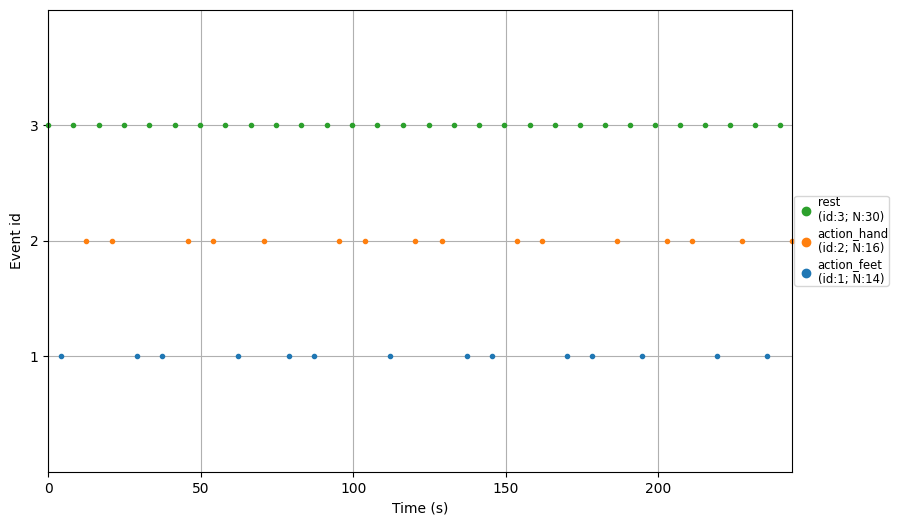

In [50]:
# plt.rcParams["figure.figsize"] = (12, 6)  
mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'], 
                     first_samp=raw_data.first_samp, event_id=event_id)
plt.show()


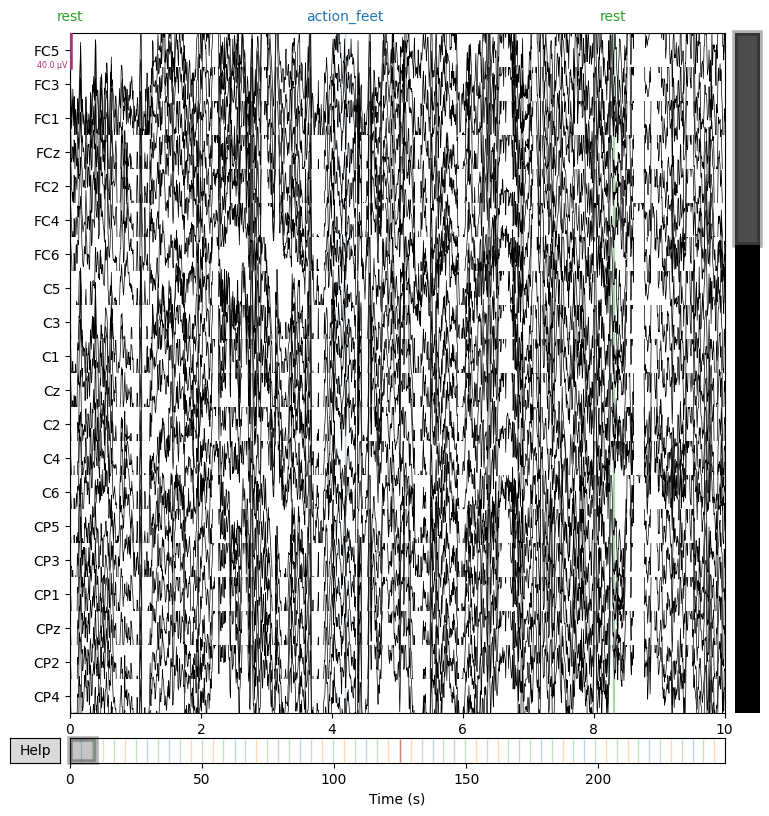

In [51]:
raw_data.plot();


### Show PSD Power Spectral Density (Plot power or amplitude spectra)

In [52]:
# data_dir = "../data/files/"

# files = [os.path.join(root, file) for root, _, files in os.walk(data_dir) for file in files if file.endswith('.edf')]

# raw_data_list = []

# for file in files:
#     print(f"Loading {file}")
#     raw = mne.io.read_raw_edf(file, preload=True)
#     raw_data_list.append(raw)

# for i, raw_data in enumerate(raw_data_list):
#     fig = raw_data.compute_psd().plot(average=True)
    
#     plt.text(0.5, 0.95, os.path.basename(files[i]), ha='center', va='center', transform=fig.axes[0].transAxes, fontsize=12)
    
#     plt.show()


In [53]:
# import os
# import mne
# import matplotlib.pyplot as plt
# import numpy as np

# data_dir = "../data/files/"

# files = [os.path.join(root, file) for root, _, files in os.walk(data_dir) for file in files if file.endswith('.edf')]

# raw_data_list = []

# for file in files:
#     print(f"Loading {file}")
#     raw = mne.io.read_raw_edf(file, preload=True)
#     raw_data_list.append(raw)

# for i, raw_data in enumerate(raw_data_list):
#     psd = raw_data.compute_psd(fmin=1, fmax=80, tmax=1.6)
#     fig = psd.plot(dB=True, picks="eeg", show=False)  # show=False para modificar antes de mostrar
    
#     # Añadir el nombre del archivo como título
#     fig.suptitle(f"Power Spectral Density ({os.path.basename(files[i])})", fontsize=14)
    
#     plt.show()


In [54]:
# # Notch filter
# notch_freq = 60
# raw_data.notch_filter(notch_freq, fir_design='firwin')
# raw_data.compute_psd().plot()


In [55]:
# # Band-pass filter keep only alpha and beta waves
# low_cutoff = 8
# high_cutoff = 30
# raw_data.filter(low_cutoff, high_cutoff, fir_design='firwin')
# raw_data.compute_psd().plot()


In [56]:
# raw_data.compute_psd().plot()
# raw_data.compute_psd().plot(average=True)


## ICA filtering

In [57]:
n_components = 20
ica = ICA(n_components=n_components, random_state=97, max_iter=800)


In [58]:
ica.fit(raw_data)


Fitting ICA to data using 64 channels (please be patient, this may take a while)


/tmp/ipykernel_2354966/3498465751.py:1: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.6s.


<ICA | raw data decomposition, method: fastica (fit in 73 iterations on 39680 samples), 20 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

In [59]:
# components_to_excludes, scores = ica.find_bads_eog(raw_data, ch_name='Fp1', threshold=3.5)
# 


In [60]:
# ica.exclude = components_to_excludes
ica.apply(raw_data)


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


<RawEDF | S001R03.edf, 64 x 39680 (248.0 s), ~19.5 MiB, data loaded>

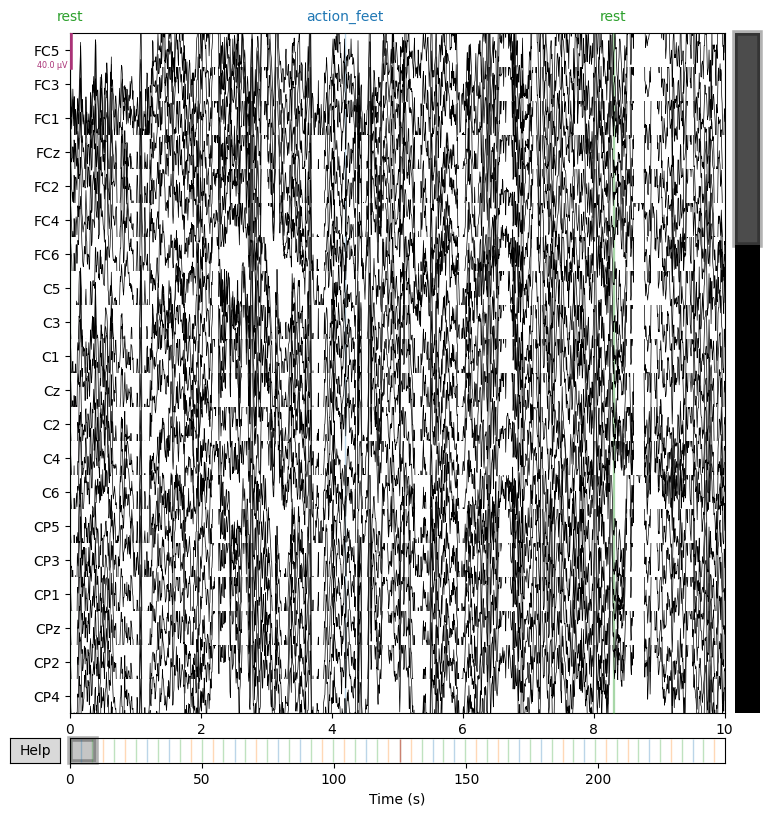

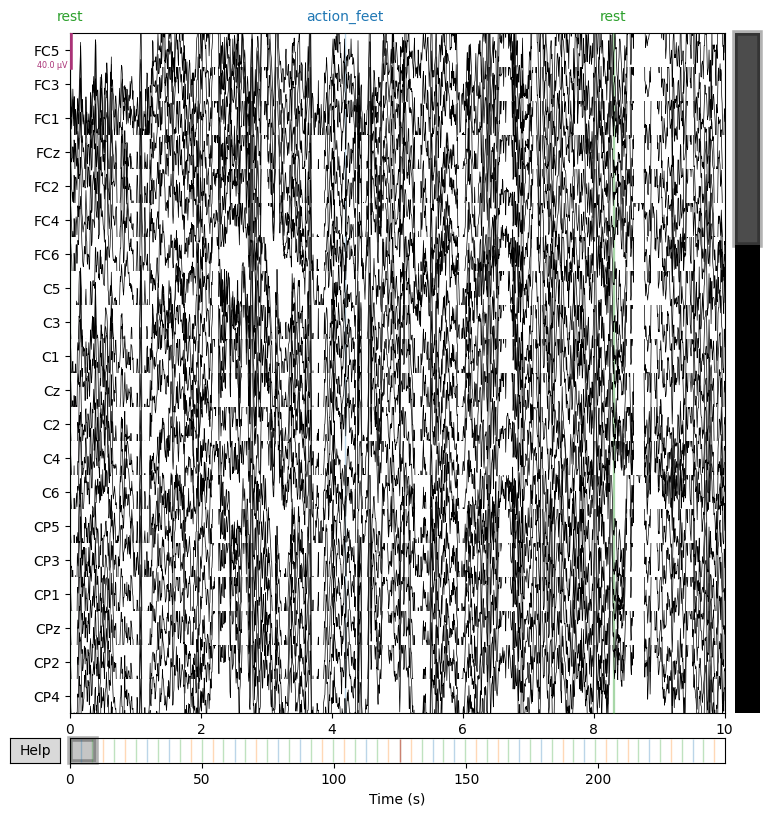

In [61]:
raw_data.plot()


In [64]:
def ica_filter(raw, picks):
    raw.filter(l_freq=1.0, h_freq=None)
    ica = mne.preprocessing.ICA(n_components=20, random_state=42)
    ica.fit(raw, picks=picks)
    eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name='Fpz')
    ica.exclude.extend(eog_indices)
    ica.apply(raw, exclude=ica.exclude)

    return raw


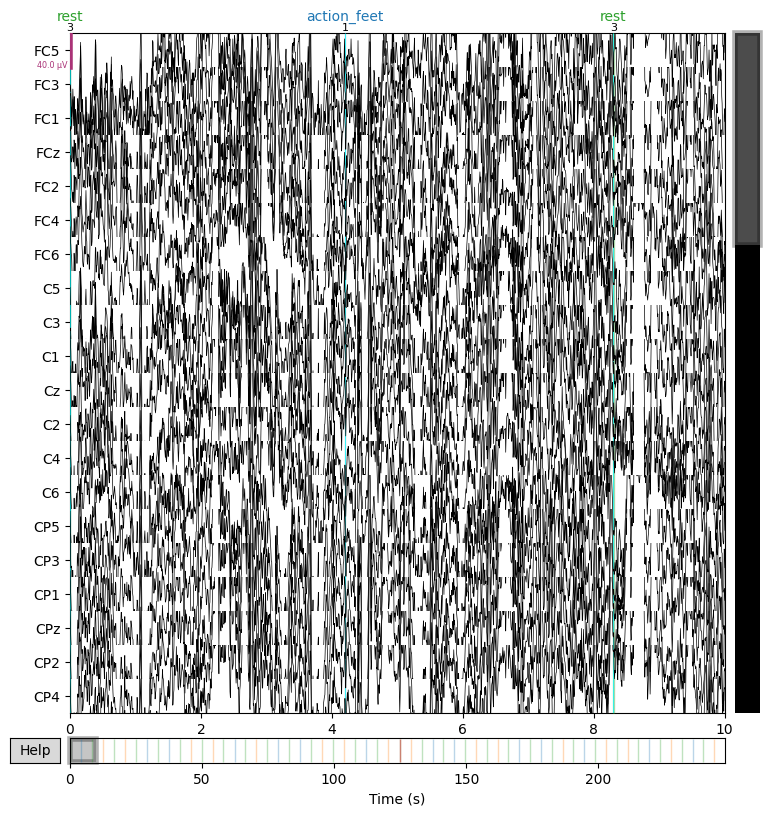

Filtering raw data in 2 contiguous segments
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 20 components
Fitting ICA took 3.5s.
Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


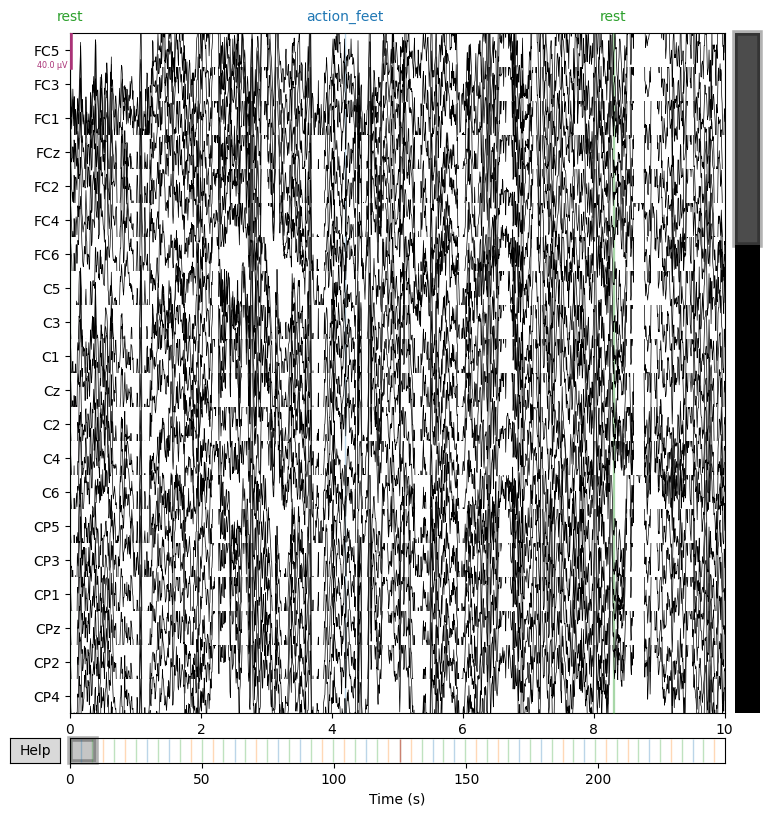

Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


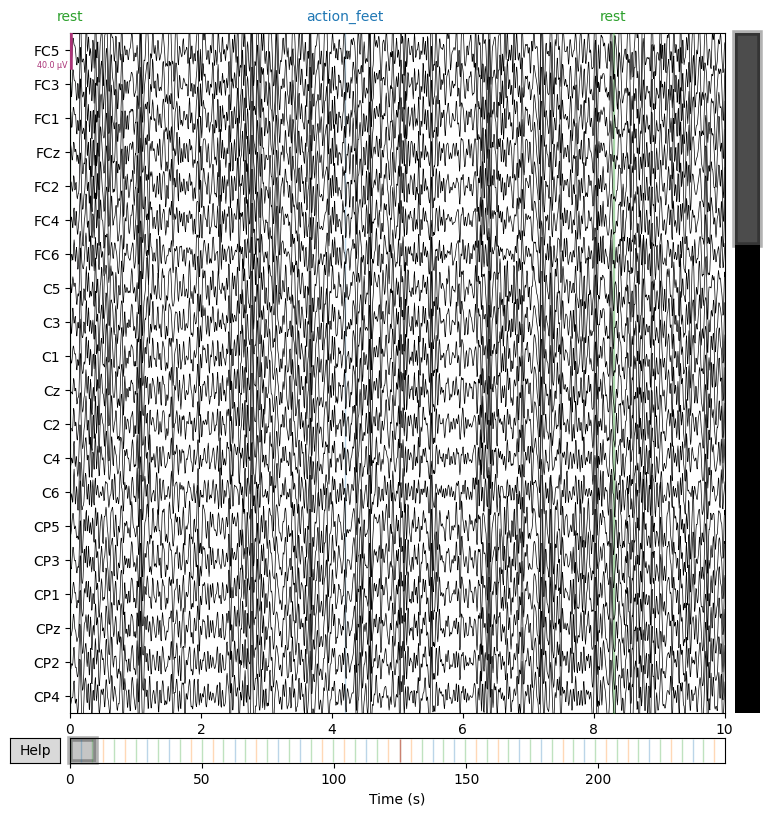

In [65]:
raw_data.plot(events=events);

raw_ica_filtered = raw_data.copy()
raw_ica_filter = ica_filter(raw_ica_filtered.copy(), picks)
raw_ica_filtered.plot();

raw_filtered = raw_ica_filtered.copy().filter(l_freq=8, h_freq=30)
raw_filtered.plot();

save_interactive_plot(raw_filtered, 'filtered_data')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


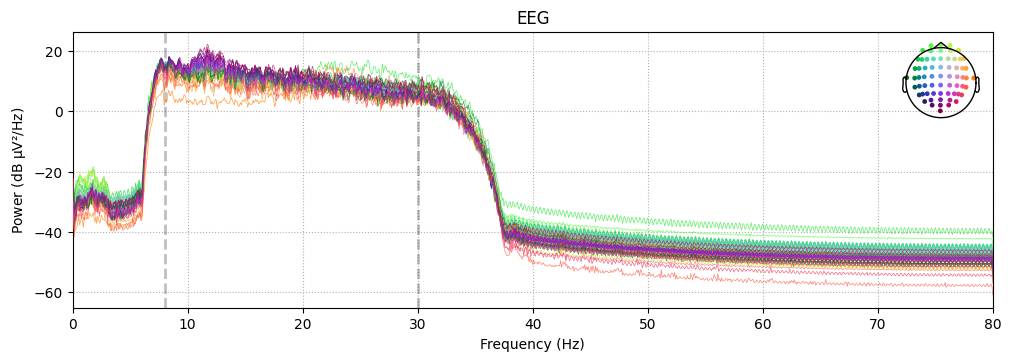

In [66]:
raw_filtered.plot_psd(average=False)
plt.show()


In [69]:
data = raw_filtered.copy().get_data()

# Standardization
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data.T).T


In [70]:
# Covariance Matrix Computation
covariance_matrix = np.cov(data_standardized)

# Eigenvalue and Eigenvector Decomposition
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# avoidng complex domain parts of eigenvalues
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

# Feature Vector Formation
# Sort eigenvalues and their corresponding eigenvectors
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


In [71]:
# Covariance Matrix Computation
covariance_matrix = np.cov(data_standardized)

# Eigenvalue and Eigenvector Decomposition
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# avoidng complex domain parts of eigenvalues
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

# Feature Vector Formation
# Sort eigenvalues and their corresponding eigenvectors
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


   Number of Components  Cumulative Explained Variance (%)
0                     1                          57.452079
1                     2                          71.037812
2                     3                          77.941792
3                     4                          81.683010
4                     5                          84.074942
5                     6                          86.109447
6                     7                          87.804777
7                     8                          89.409938
8                     9                          90.520230
9                    10                          91.523376




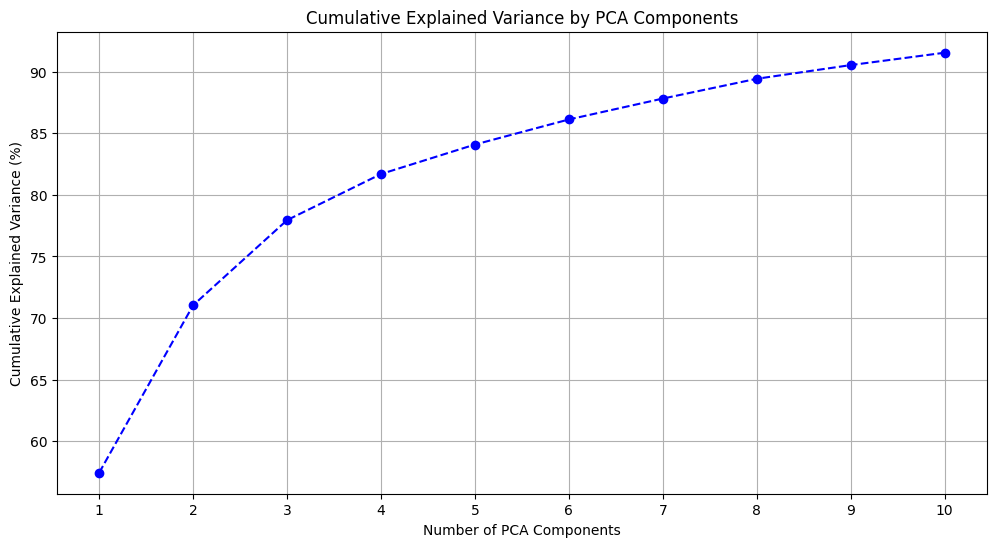

In [73]:
# Calculate the cumulative explained variance
explained_variance_ratio = np.cumsum(eigenvalues) / np.sum(eigenvalues) * 100

# Create a DataFrame with the number of components and cumulative variance
df_explained_variance = pd.DataFrame({
    'Number of Components': range(1, len(eigenvalues) + 1),
    'Cumulative Explained Variance (%)': explained_variance_ratio
})

# Display the DataFrame 10 first rows
print(f"{df_explained_variance.head(10)}\n\n")

# Select the top k eigenvectors
k = 10  # Number of principal components to keep
eigenvectors_reduced = eigenvectors[:, :k]

# Recast the Data
data_pca = np.dot(eigenvectors_reduced.T, data_standardized)

# Visualize the cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(range(1, k + 1), explained_variance_ratio[:k], marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.xticks(range(1, k + 1))
plt.grid()
plt.show()

